<a href="https://colab.research.google.com/github/JSA-V/Dispectrum/blob/main/Dispectrum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Dispectrum*: a spectrum class for computing and representing (both visually and aurally) sound spectra and their Sethares and Vassilakis' dissonance curves. It relies on the module consonance_models, which has the mathematical definitions of these curves. Developed by Juan Sebastián Arias-Valero, jsariasv1@gmail.com, 2022.


In [ ]:
# load to session consonance_models module
!wget -O consonance_models.py 'https://www.dropbox.com/s/qae8z9aljbn8394/consonance_models.py?dl=0'

# load to session some timbre samples
!wget -O plain_wave.wav 'https://www.dropbox.com/s/wdxeua4k40nase4/plain_wave.wav?dl=0'
!wget -O organ.wav 'https://www.dropbox.com/s/bip6k05g3ix3612/organ.wav?dl=0'
!wget -O flute.wav 'https://www.dropbox.com/s/0fnnskx5uxz1ju3/flute.wav?dl=0'
!wget -O trumpet.wav 'https://www.dropbox.com/s/gh9ee82ophnr2ah/trumpet.wav?dl=0'


--2022-12-15 02:04:59--  https://www.dropbox.com/s/qae8z9aljbn8394/consonance_models.py?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/qae8z9aljbn8394/consonance_models.py [following]
--2022-12-15 02:05:00--  https://www.dropbox.com/s/raw/qae8z9aljbn8394/consonance_models.py
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6007a2a633bbde7cece2389f00.dl.dropboxusercontent.com/cd/0/inline/Byo1dJzKEBdAC0YwroA3vTJ1gm_30v5rPfdZKOjB6nDsTys30oubr4wQ338toqnIDIrzhzrlqfZSt9iSTMcI1S2lFOG1FVzufwCfbsg8pnoVkSPNmKarsQxcnoO-kfWn5h9MFYdYRzXL7TUorZbYgLvTy-BZS2n8l8qyhPiK91h6lw/file# [following]
--2022-12-15 02:05:00--  https://uc6007a2a633bbde7cece2389f00.dl.dropboxusercontent.com/cd/0/inline/Byo1dJzKEBdAC0YwroA3vTJ1gm_30v5rPfdZKOjB6nDsTys3

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from consonance_models import D, D2, Dis, Dis2, Disi2
from scipy.io.wavfile import write,read
from matplotlib.animation import FuncAnimation
from scipy.fft import rfft,rfftfreq
from scipy.optimize import minimize 
import pandas as pd

class Spectrum:
    
    def __init__(self, fundamental, frequency_ratios=None, amplitude_vector=None):
        self.fundamental = fundamental
        self.frequency_ratios = np.array(frequency_ratios)
        if frequency_ratios!=None:
            self.frequency_vector = fundamental*self.frequency_ratios  
        # we assume it has normalized amplitudes
        self.amplitude_vector = np.array(amplitude_vector)
        self.sound = None
        self.sound_samplig_rate = None
        self.sound_name = None
        plt.matplotlib.rc('figure', figsize = (15,4.8)) # plots size
        
    def plot_spectrum(self):
        f=self.fundamental
        R=self.frequency_ratios
        A=self.amplitude_vector
        plt.xlabel('frequency ratios')
        plt.ylabel('amplitude ratios')
        plt.title('sound spectrum')
        plt.plot(R,A,'o')
        plt.grid()
    
    def dissonance(self,model_name):
        F=self.frequency_vector
        A=self.amplitude_vector
        return D(F,A,model_name)
    
    def dissonance2(self,other,model_name):
        F1=self.frequency_vector
        A1=self.amplitude_vector
        F2=other.frequency_vector
        A2=other.amplitude_vector
        return D2(F1,A1,F2,A2,model_name)
        
    def dissonance_curve(self, model_name):
        self.dissonance_curve2(self,model_name)
   
    def dissonance_curve2(self, other, model_name):
        F1=self.frequency_vector
        A1=self.amplitude_vector
        F2=other.frequency_vector
        A2=other.amplitude_vector
        alpha = np.linspace(1, 2, 500) # varying-frequency ratios
        if max(len(F1),len(F2))<=50:
            vectorDisT=Dis2(F1,A1,F2,A2,alpha,model_name)
        else:
            vectorDisT=Disi2(F1,A1,F2,A2,alpha,model_name) # to avoid RAM overload
        # maximum
        i=np.argmax(vectorDisT) # maximum-dissonance index
        M=vectorDisT[i] # maximum dissonance
        print('Maximum close to {} with value {}'.format(alpha[i],M))
        
        # plot         
        plt.plot(alpha, vectorDisT/M,color='black')
        plt.plot(alpha[i],1,'o',color='black')
        plt.show()
        
    def dissonance_curve_audio(self,n_channels):
        self.dissonance_curve_audio2(self,n_channels)

    def dissonance_curve_audio2(self,other,n_channels):
        sampling_rate = 5000
        ts=other.fundamental #duration
        num_samples = int(sampling_rate*ts)
        amp_factor = np.iinfo(np.int16).max # format
        t=np.linspace(0,ts,num_samples) # frequency varies as time
        
        # waves 
        F1=self.frequency_vector
        A1=self.amplitude_vector
        F2=other.frequency_vector
        A2=other.amplitude_vector
        n=len(F1)
        sound1=A1[0]*np.sin(2*np.pi*F1[0]*t)
        for i in range(1,n): # sum of partials
            sound1+=A1[i]*np.sin(2*np.pi*F1[i]*t) 
        sound2=0
        for i,f in enumerate(F2): # varying tone
            sound2+=A2[i]*np.sin(2*np.pi*(f+t)*t)     
            
        # writing
        if n_channels==2: # binaural
            Max=max(np.max(sound1),np.max(sound2))
            sound1=sound1/Max # normalize
            sound2=sound2/Max
            sound=np.array([sound1,sound2]).T
            write("dissonance_curve_binaural.wav", sampling_rate, (amp_factor*sound).astype(np.int16))
        elif n_channels==1: # mono  
            sound=sound1+sound2
            Max=np.max(sound)
            sound=sound/Max
            write("dissonance_curve_mono.wav", sampling_rate, (amp_factor*sound).astype(np.int16))  
    
    def dissonance_curve_animation(self,model_name):
        return self.dissonance_curve_animation2(self,model_name)
        
    def dissonance_curve_animation2(self,other,model_name):
        f=other.fundamental
        F1=self.frequency_vector
        A1=self.amplitude_vector
        F2=other.frequency_vector
        A2=other.amplitude_vector
        R2=other.frequency_ratios
        alpha = np.linspace(1, 2, 500)
        vectorDisT=Dis2(F1,A1,F2,A2,alpha,model_name)

        fig, ax = plt.subplots()
        xdata, ydata = [], []
        ln, = plt.plot([], [],   marker='o', color='red',markeredgecolor='black')
        
        def init():
            return  plt.plot(alpha*f, vectorDisT)
        
        def update(frame):
            xdata.append(frame)
            g=frame
            G=g*R2
            Distotal=D2(F1,A1,G,A2,model_name)
            ydata.append(Distotal)
            ln.set_data(xdata, ydata)
            return ln,
        
        #Parameters
    
        fps=1 # frames per second 
        d=2*f-f #duration of the animation: nf/fps  
        nf=d*fps # nf: number of frames of the animation
        interval=1000/fps #Delay between frames in milliseconds = 1000/frames_per_second (default=200)
        
        ani = FuncAnimation(fig, update, frames=np.arange(f,2*f, 1), interval=1000,init_func=init)#, blit=True)
        plt.rcParams['animation.html'] = 'html5'
        return ani
    
    def load_wav(self,file_name):
        self.sound_name=file_name
        self.sampling_rate, self.sound = read(file_name)
        n_samples=len(self.sound)
        print('Name:',file_name)
        print('Sampling rate:',self.sampling_rate)
        print('Number of samples:',n_samples)
        print('Format:',self.sound.dtype)
        print('Maximum {} and minimum {}'.format(max(self.sound),min(self.sound)))
        print('Duration: {} seconds'.format(n_samples/self.sampling_rate))
        print('************')
    
    def calculate_sound_spectrum(self, time_on, time_off, epsilon=0.01):
        sampling_rate=self.sampling_rate
        sound=self.sound
        sound=sound[time_on*sampling_rate:time_off*sampling_rate]
        amp_factor= np.iinfo(np.int16).max # TODO: other formats?
        n_samples=len(sound)
        
        spec = rfft(sound) # includes complex numbers
        freq = rfftfreq(n_samples) 
        A=np.abs(spec) # modules of the complex spectrum
        a=A/np.max(A)  # normalization
        I=np.where(a>epsilon)  #indices of amplitude ratio >ε
        print('Total frequencies with amplitude ratio above {}: {}'\
        .format(epsilon,len(I[0])))
        print('')
        F=freq[I]*sampling_rate # we need this product to obtain proper frequencies
        A=a[I]
        
        # updating
        self.frequency_vector = F
        self.frequency_ratios = F/self.fundamental
        self.amplitude_vector = A
     
    def maximum_dissonance_table(self,others,model_name):
        # varying-frequencies ratios
        alpha = np.linspace(1, 2, 1000)
        max_ratios=[]
        max_frequencies=[]
        sound_names=[]
        
        for S in [self]+others:
            sound_names.append(S.sound_name[:-4]) # deletes '.wav'
            F=S.frequency_vector
            A=S.amplitude_vector
            
            def dis(alpha):
                return -Dis(F,A,alpha,model_name) 
        
            # maximum
            m=minimize(dis,1,method='Nelder-Mead')
            x=m.x[0]
            y=-m.fun
            #print('Maximum close to {} with value {}'.format(x,y))
            
            max_ratios.append(x)
            f=S.fundamental
            max_frequencies.append(f*x)
        
        # dictionary
        D={'timbre':sound_names,
           'max_dis_freq.':np.round(max_frequencies,2),
           'ratio':max_ratios}
        
        return pd.DataFrame(data=D)

The following cells are a tutorial on the Spectrum class.


In [ ]:
# create spectrum

f=220 
#r=[1,1.8, 2**(0.3), 4**(np.pi)] 
r=[1]
a=[1]
#a=[1,0.8,0.7,0.6]
S=Spectrum(fundamental=f,frequency_ratios=r,amplitude_vector=a)

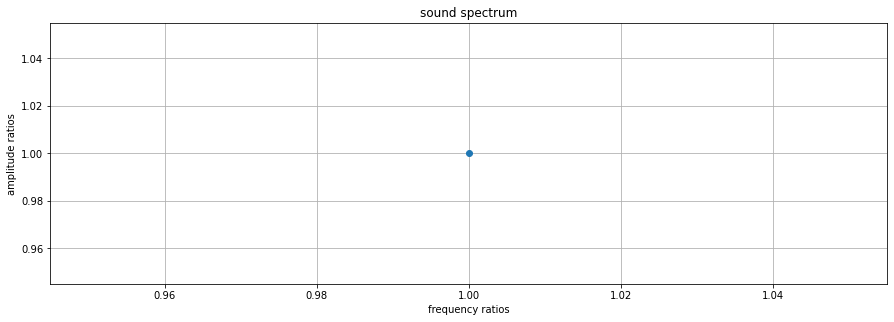

In [ ]:
# plot spectrum

S.plot_spectrum()

In [ ]:
# dissonance

S.dissonance('Sethares1') , S.dissonance('Vassilakis')

(0.0, 0.0)

In [ ]:
# dissonance between two spectra

# new spectrum
f=200 
r=[1,1.4, 1.6, np.pi] 
a=[1,0.7,0.4,0.5]
T=Spectrum(fundamental=f,frequency_ratios=r,amplitude_vector=a)

S.dissonance2(T,'Sethares1'), S.dissonance2(T,'Vassilakis')

(0.3309832664069546, 0.1530200882861745)

Maximum close to 1.0981963927855711 with value 0.09038723953257086


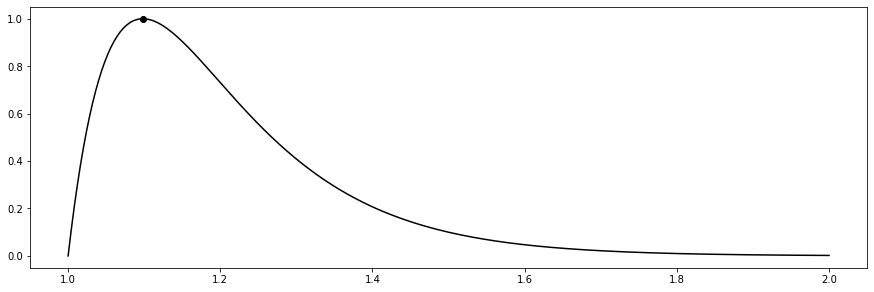

In [ ]:
# dissonance curve

S.dissonance_curve('Vassilakis')

In [ ]:
# dissonance curve audio

T.dissonance_curve_audio(1) # mono
T.dissonance_curve_audio(2) # two channels

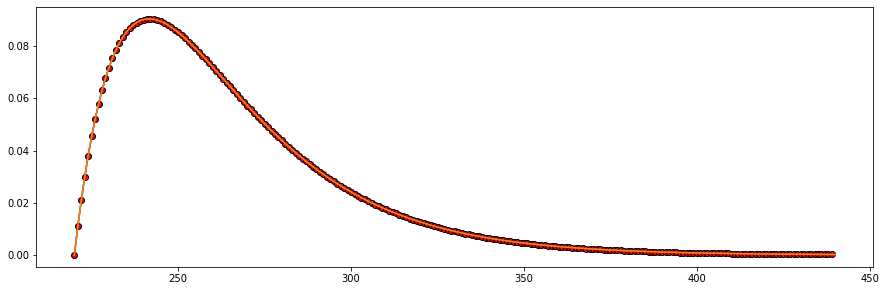

In [ ]:
# dissonance curve animation

S.dissonance_curve_animation('Vassilakis')

In [ ]:
# load wav file

f=440*2**(-9/12) # middle C
S=Spectrum(fundamental=f)
S.load_wav('plain_wave.wav')

Name: plain_wave.wav
Sampling rate: 48000
Number of samples: 240000
Format: int16
Maximum 32766 and minimum -32766
Duration: 5.0 seconds
************


Total frequencies with amplitude ratio above 0.01: 74



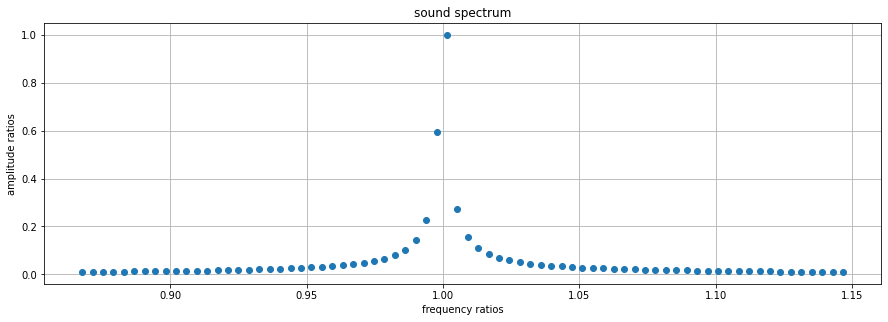

In [ ]:
# calculate sound spectrum

S.calculate_sound_spectrum(1,2)
S.plot_spectrum()

In [ ]:
# maximum-dissonance table 

names=['organ.wav','flute.wav','trumpet.wav']
Spectra=[]
for name in names:
    T=Spectrum(fundamental=f)
    T.load_wav(name)
    T.calculate_sound_spectrum(1,2)
    Spectra.append(T)
    
S.maximum_dissonance_table(Spectra,'Vassilakis')

Name: organ.wav
Sampling rate: 44100
Number of samples: 511996
Format: int16
Maximum 14767 and minimum -15113
Duration: 11.609886621315193 seconds
************
Total frequencies with amplitude ratio above 0.01: 225

Name: flute.wav
Sampling rate: 44100
Number of samples: 2692174
Format: int16
Maximum 1867 and minimum -1840
Duration: 61.04702947845805 seconds
************
Total frequencies with amplitude ratio above 0.01: 450

Name: trumpet.wav
Sampling rate: 44100
Number of samples: 2706671
Format: int16
Maximum 3741 and minimum -3484
Duration: 61.37575963718821 seconds
************
Total frequencies with amplitude ratio above 0.01: 324



,timbre,max_dis_freq.,ratio
0,plain_wave,283.11,1.082129
1,organ,274.71,1.050000
2,flute,271.95,1.039453
3,trumpet,271.42,1.037451


In [ ]:
# load wav file and generate complex audios (see session files for the output)

f=440*2**(-9/12) # central C
S=Spectrum(fundamental=f)
S.load_wav('flute.wav')
S.calculate_sound_spectrum(1,2)
S.dissonance_curve_audio(1) # mono
S.dissonance_curve_audio(2) # stereo

Name: flute.wav
Sampling rate: 44100
Number of samples: 2692174
Format: int16
Maximum 1867 and minimum -1840
Duration: 61.04702947845805 seconds
************
Total frequencies with amplitude ratio above 0.01: 450



Maximum close to 1.0400801603206413 with value 528.4476152123542


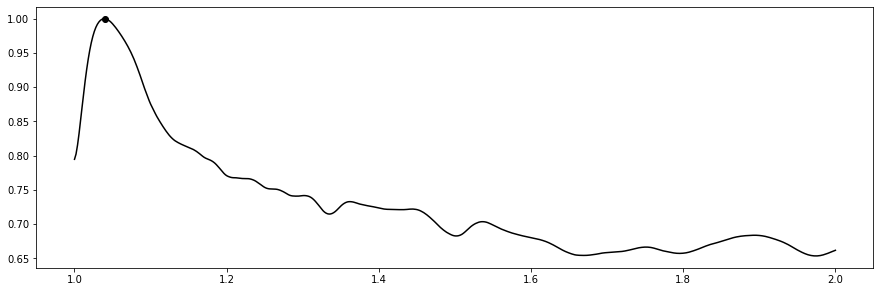

In [ ]:
S.dissonance_curve('Vassilakis')

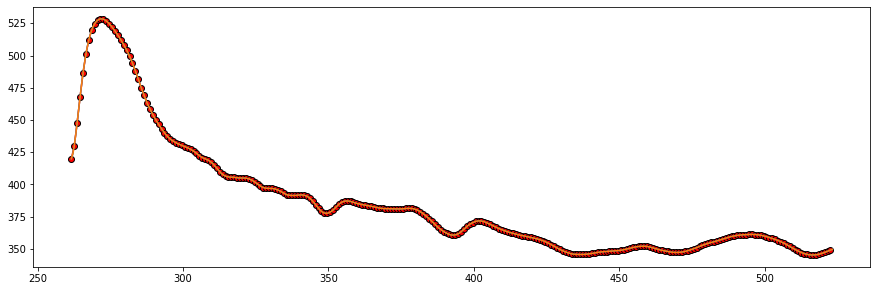

In [ ]:
S.dissonance_curve_animation('Vassilakis')

Name: trumpet.wav
Sampling rate: 44100
Number of samples: 2706671
Format: int16
Maximum 3741 and minimum -3484
Duration: 61.37575963718821 seconds
************
Total frequencies with amplitude ratio above 0.01: 324

Maximum close to 1.0400801603206413 with value 342.6524937242041


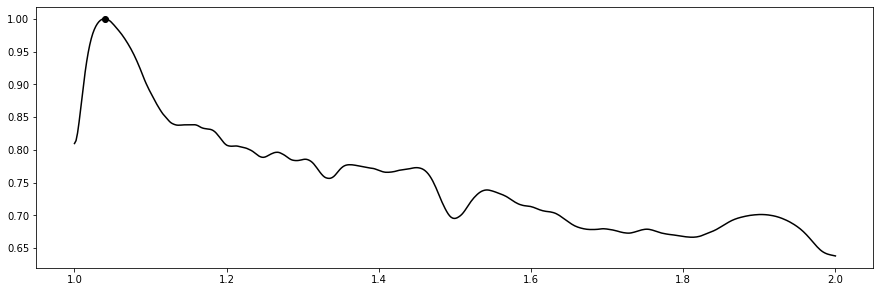

In [ ]:
T=Spectrum(fundamental=f)
T.load_wav('trumpet.wav')
T.calculate_sound_spectrum(1,2)

S.dissonance_curve2(T,'Vassilakis')
S.dissonance_curve_audio2(T,1) 

Maximum close to 1.034068136272545 with value 345.1046467091819


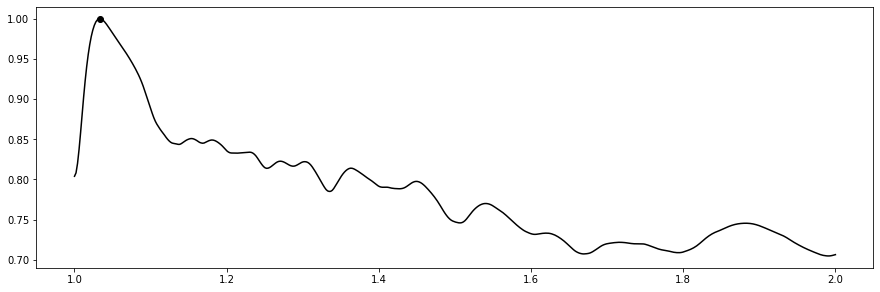

In [ ]:
T.dissonance_curve2(S,'Vassilakis')
T.dissonance_curve_audio2(S,1)